# Tree based methods

J. Renero<br>
January 2019

Trees construct prediction models from data. They recursively partition the data space to fit a boolean prediction model within each partition. The result is represented graphically as a decision tree. Trees can be used for regression of classification.

When the number of features, $p$, is large interpretability is easier than in distance based methods or probabilistic classification, where boundaries are much more difficult to be explained in higer dimensions.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tree-based-methods" data-toc-modified-id="Tree-based-methods-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tree based methods</a></span><ul class="toc-item"><li><span><a href="#Regression-Example" data-toc-modified-id="Regression-Example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Regression Example</a></span><ul class="toc-item"><li><span><a href="#Load-the-data-and-split-the-dataset" data-toc-modified-id="Load-the-data-and-split-the-dataset-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Load the data and split the dataset</a></span></li><li><span><a href="#Fit-a-simple-regression-tree-(no-CV)" data-toc-modified-id="Fit-a-simple-regression-tree-(no-CV)-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Fit a simple regression tree (no CV)</a></span></li><li><span><a href="#Display-the-tree" data-toc-modified-id="Display-the-tree-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Display the tree</a></span></li><li><span><a href="#Variables-Importance" data-toc-modified-id="Variables-Importance-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Variables Importance</a></span></li><li><span><a href="#Evaluating-the-tree" data-toc-modified-id="Evaluating-the-tree-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Evaluating the tree</a></span></li></ul></li><li><span><a href="#Classification-Example" data-toc-modified-id="Classification-Example-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Classification Example</a></span><ul class="toc-item"><li><span><a href="#Display-the-tree" data-toc-modified-id="Display-the-tree-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Display the tree</a></span></li><li><span><a href="#Variables-importance" data-toc-modified-id="Variables-importance-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Variables importance</a></span></li><li><span><a href="#Evaluating-the-tree" data-toc-modified-id="Evaluating-the-tree-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluating the tree</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import graphviz

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  

%matplotlib inline

## Regression Example

We will start by building a simple regression example with the [wholesale customer dataset in UCI](https://archive.ics.uci.edu/ml/datasets/wholesale+customers). It contains 440 samples of 8 variables, and we will try to build a model that will help us to predict the annual spending on fresh products (first variable) with a regression tree.

### Load the data and split the dataset

In [2]:
class Split:
    """
    This class represents a split from a dataset, it will assign
    each dataframe partition passed as argument to a different 
    attribute of the class: 'train', 'test' (and 'validation').
    The class method 'split' performs the splitting of the dataframe
    passed, according to the parameters passed.
    
    Example:
    
        X, Y = Split.split(my_data, my_target)
        
    """
    split_name = ['train', 'test', 'validation']
    
    def __init__(self, splits):
        for index, partition in enumerate(splits):
            setattr(self, self.split_name[index], partition)

    @classmethod
    def split(cls,
              data, 
              target, 
              seed=1024, 
              test_size=0.2, 
              validation_split=False):
        """
        From an input dataframe, separate features from target, and 
        produce splits (with or without validation).
        """
        features = list(data)
        features.remove(target)
        X = pd.DataFrame(data, columns=features)
        Y = pd.DataFrame(data.loc[:, target])

        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, 
            test_size=test_size, random_state=seed)

        if validation_split is True:
            X_train, X_val, Y_train, Y_val = train_test_split(
                X_train, Y_train, 
                test_size=test_size, random_state=seed)
            X_splits = [X_train, X_test, X_val]
            Y_splits = [Y_train, Y_test, Y_val]
        else:
            X_splits = [X_train, X_test]
            Y_splits = [Y_train, Y_test]

        return Split(X_splits), Split(Y_splits)

In [3]:
class Dataset:
    """
    This class allows a simpler representation of the dataset used
    to build a model in class. It allows loading a remote CSV by
    providing an URL to the initialization method of the object.

        my_data = Dataset(URL)
        
    """
    def __init__(self, data_location):
        self.data = pd.read_csv(data_location)
        
    def target(self, target):
        self.features = list(self.data)
        self.features.remove(target)
        self.target = target

In [4]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
wholesale = Dataset(data_url)
wholesale.target('Fresh')
X, Y = Split.split(wholesale.data, wholesale.target)

### Fit a simple regression tree (no CV)

In [5]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=3)
regressor.fit(X.train, Y.train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

### Display the tree

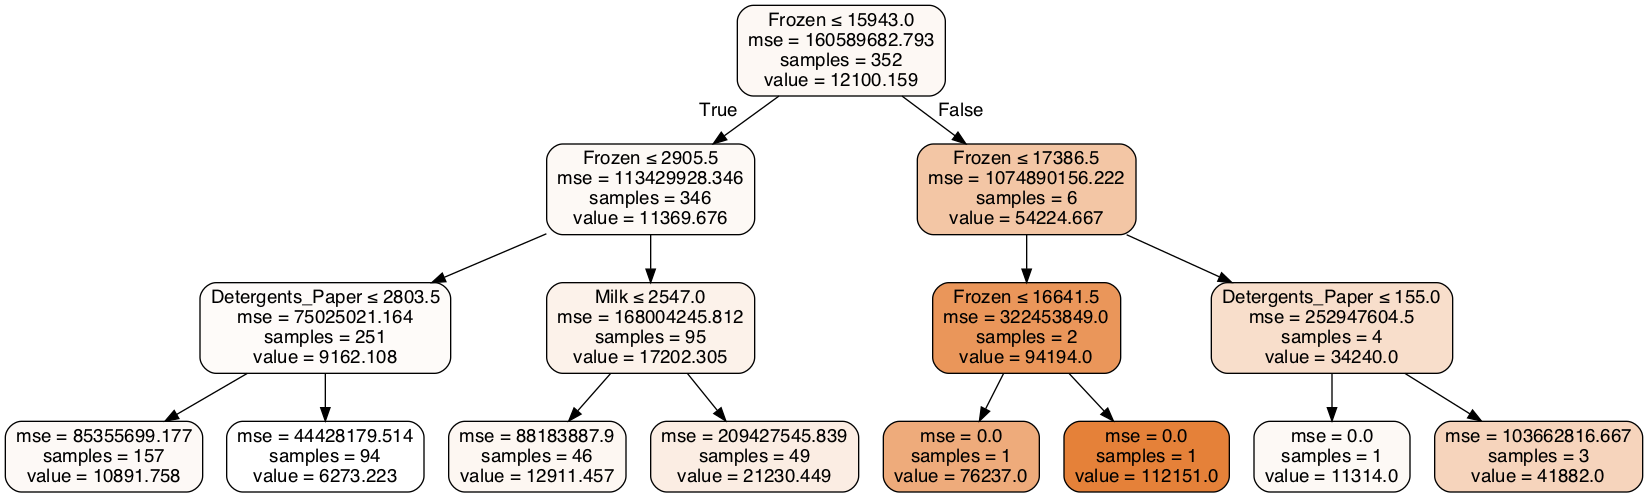

In [6]:
def display_tree(tree, features):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,
                    feature_names=features,
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    image = Image(graph.create_png())
    display(image)
    
display_tree(regressor, wholesale.features)

### Variables Importance

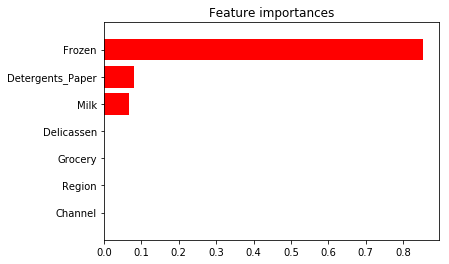

In [7]:
def features_importance(tree, X):
    """
    Plot the variables importance from the fitted tree and the 
    training dataset used.
    """
    importances = tree.feature_importances_
    indices = np.argsort(importances)

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(X.train.shape[1]), importances[indices],
           color="r", align="center")

    index_names = [list(X.train)[i] for i in indices]

    plt.yticks(range(X.train.shape[1]), index_names)
    plt.ylim([-1, X.train.shape[1]])
    plt.show()

features_importance(regressor, X)

Understanding the tree structure (partially from [here](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py))

In [8]:
def explain_tree(regressor):
    n_nodes = regressor.tree_.node_count
    children_left = regressor.tree_.children_left
    children_right = regressor.tree_.children_right
    feature = regressor.tree_.feature
    threshold = regressor.tree_.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    for i in range(n_nodes):
        if is_leaves[i]:
            print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else:
            print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     feature[i],
                     threshold[i],
                     children_right[i],
                     ))

explain_tree(regressor)

The binary tree structure has 15 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 4] <= 15943.0 else to node 8.
	node=1 test node: go to node 2 if X[:, 4] <= 2905.5 else to node 5.
		node=2 test node: go to node 3 if X[:, 5] <= 2803.5 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 test node: go to node 6 if X[:, 2] <= 2547.0 else to node 7.
			node=6 leaf node.
			node=7 leaf node.
	node=8 test node: go to node 9 if X[:, 4] <= 17386.5 else to node 12.
		node=9 test node: go to node 10 if X[:, 4] <= 16641.5 else to node 11.
			node=10 leaf node.
			node=11 leaf node.
		node=12 test node: go to node 13 if X[:, 5] <= 155.0 else to node 14.
			node=13 leaf node.
			node=14 leaf node.


### Evaluating the tree

What's the $R^2$ of this tree when making predictions? The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

In [9]:
def evaluate_regressor(tree, X, Y):
    """
    Evaluates a tree with the data values passed, returning the R2 and MSE
    """
    r2 = tree.score(X, Y)
    e = tree.predict(X)
    mse = np.average(np.power((e - Y.values), 2))
    return r2, mse

r2, mse = evaluate_regressor(regressor, X.test, Y.test)
print('The R2 of the regressor is: {:.4f}'.format(r2))
print('The MSE is: {:.4f}'.format(mse))

The R2 of the regressor is: -0.8044
The MSE is: 314539617.0210


If we evaluate the regressor with the function just described above, for a range of trees where the maximum depth ranges from 3 to 20, what we can see is the result oscilates a little bit but they're not specially good. The performance of a regression tree in this problem is specially bad. **Trees are not very good for regression problems** with features in a continuous space.

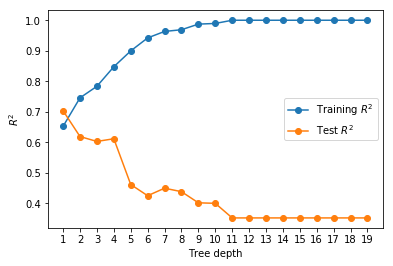

In [20]:
# Plot the $R^2$ values obtained when varying the depth of the tree
min_depth = 1
max_depth = 20
r2s_train = []
r2s_test = []
for i in range(min_depth, max_depth):
    tree = DecisionTreeRegressor(random_state=0, max_depth=i).fit(X.train, Y.train)
    r2, _ = evaluate_regressor(tree, X.train, Y.train)
    r2s_train.append(r2)
    r2, _ = evaluate_regressor(tree, X.test, Y.test)
    r2s_test.append(r2)
    del(tree)
    
plt.plot(r2s_train, 'o-', label='Training $R^2$')
plt.plot(r2s_test, 'o-', label='Test $R^2$')
plt.xticks(range(min_depth-1, max_depth-1), ['{}'.format(i) for i in range(min_depth, max_depth)])
plt.xlabel('Tree depth')
plt.ylabel('$R^2$')
plt.legend()
plt.show()

## Classification Example

Let's build, using the same dataset a classification case. To do so the goal of this new model will be predicting the channel used by the customer (1 or 2), so we have a **binomial** classification problem.

In [11]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
wholesale = Dataset(data_url)
wholesale.target('Channel')

X, Y = Split.split(wholesale.data, wholesale.target)

classifier = DecisionTreeClassifier(random_state=0, max_depth=3)
classifier.fit(X.train, Y.train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

### Display the tree

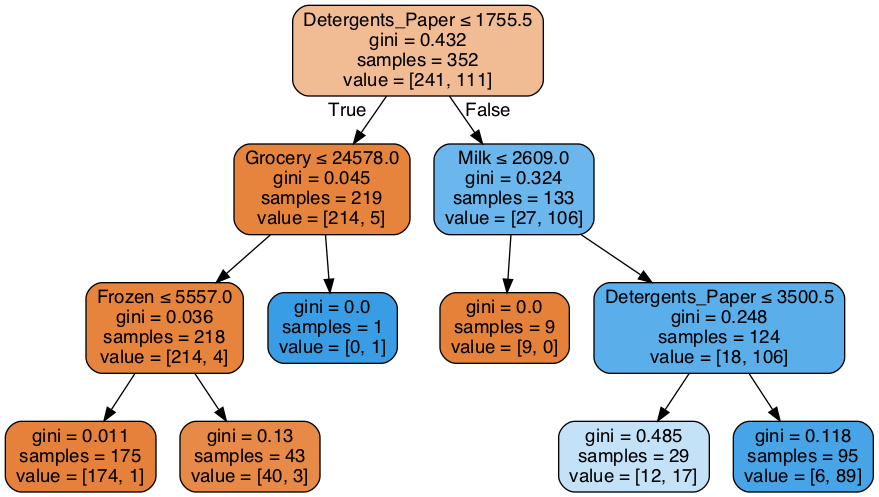

In [12]:
display_tree(classifier, wholesale.features)

### Variables importance

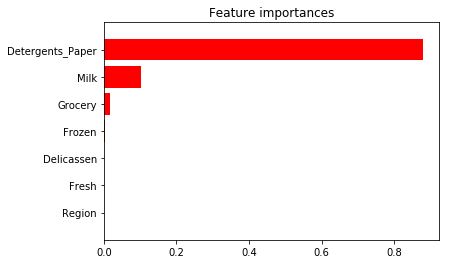

In [13]:
features_importance(classifier, X)

### Evaluating the tree

This case, the evaluation metric is the GINI index.

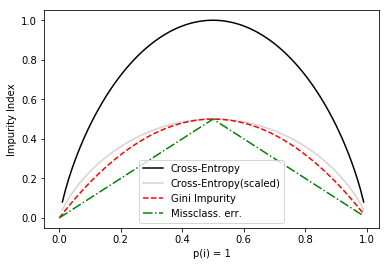

In [21]:
# Plot the Entropy, Gini Index and missclassification error curves
def gini(p):
    return (p)*(1 - (p)) + (1 - p)*(1 - (1 - p))

def cross_entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)
ent = [cross_entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                        ['Cross-Entropy','Cross-Entropy(scaled)',
                        'Gini Impurity', 'Missclass. err.'],
                        ['-','-','--','-.'],
                        ['black','lightgrey','red','green','cyan']):
    line = plt.plot(x, i, label=lab, linestyle=ls, color=c)
plt.legend(loc='best')
plt.xlabel('p(i) = 1')
plt.ylabel('Impurity Index')
plt.show()

In [15]:
def evaluate_classifier(tree, X, Y):
    """
    Evaluates a tree with the data values passed, returning the R2 and MSE
    """
    miss_rate = 1.0 - tree.score(X, Y)
    return miss_rate

miss_rate = evaluate_classifier(classifier, X.test, Y.test)
print('The missclassification error rate is: {:.4f}'.format(miss_rate))

The missclassification error rate is: 0.0909


We can see that if we vary the depth of the tree from 3 up to 19, the trend is that the error rate grows.... which sounds counterintuitive, as we're making our tree better and better. The explanation is very easy: we're overfitting. Trees are prone to increase variance, and thus produce a worse generalization.

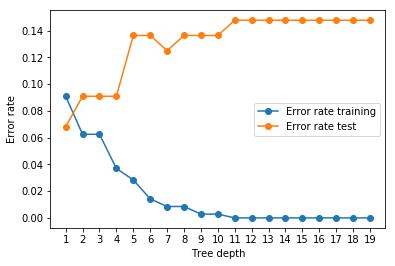

In [19]:
# Plot the $R^2$ values obtained when varying the depth of the tree
min_depth = 1
max_depth = 20
mers_train = []
mers_test = []
for i in range(min_depth, max_depth):
    tree = classifier = DecisionTreeClassifier(random_state=0, max_depth=i).fit(X.train, Y.train)
    mer = evaluate_classifier(tree, X.train, Y.train)
    mers_train.append(mer)
    mer = evaluate_classifier(tree, X.test, Y.test)
    mers_test.append(mer)
    del(tree)
    
plt.plot(mers_train, 'o-', label='Error rate training')
plt.plot(mers_test, 'o-', label='Error rate test')
plt.xticks(range(min_depth-1, max_depth-1), ['{}'.format(i) for i in range(min_depth, max_depth)])
plt.xlabel('Tree depth')
plt.ylabel('Error rate')
plt.legend()
plt.show()